**Loading and Preprocessing Image Datasets with PyTorch**

Link to Dataset: https://www.kaggle.com/datasets/nafishamoin/new-bangladeshi-crop-disease

1. Install Libraries

In [ ]:
# !pip install torch
# !pip install torchvision
# !pip install numpy
# !pip install matplotlib

2. Importing libraries

In [ ]:
# !pip install torchvision

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time
import seaborn
import matplotlib.pyplot as plt

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Hyperparameters
NUM_CLASSES = 14
batch_size = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
IMAGE_SIZE = 224

3. **Loading the Dataset**

   We will use the torchvision.datasets.ImageFolder to load the dataset.
   
   **Generate a Kaggle API Key**
   Go to your Kaggle account settings: https://www.kaggle.com/account/account

   Scroll down to the "API" section.

   Click on "Create New API Token".

   This will download a file named kaggle.json containing your API key.
   Upload the Kaggle API Key to Google Colab                                                
   In your Google Colab notebook, create a new cell and run the following code
   to upload the kaggle.json file:                                                                        Click on "Choose Files" and select the kaggle.json file from your local machine.        


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle2.json to kaggle2.json


{'kaggle2.json': b'{"username":"duncanngacha","key":"35484c009335c3e1468b92ca02e83629"}'}

       Move the API Key to the Correct Directory
       Run the following commands in a new cell to create the .kaggle directory and move the kaggle.json file to it:
       

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle2.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle2.json

      Download the Dataset
      

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nafishamoin/new-bangladeshi-crop-disease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-bangladeshi-crop-disease


In [ ]:
!mkdir -p ./SDS-CP028
#!mv /root/.cache/kagglehub/datasets/nafishamoin/new-bangladeshi-crop-disease/versions/2 ./SDS-CP028/

!cp -r /kaggle/input/new-bangladeshi-crop-disease ./SDS-CP028/

In [ ]:
import os
import shutil
import random

# Set random seed for reproducibility
random.seed(42)

# Paths
original_dataset_dir = './SDS-CP028/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease'  # Root path where Corn, Potato, etc. folders are
base_dir = 'SmartLeaf_dataset'                            # Where you want to create train/val/test folders
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
# test_ratio = 0.1 (implicitly the remaining)

# Create train, val, and test directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Traverse two levels: crop -> class
for crop_folder in os.listdir(original_dataset_dir):
    crop_path = os.path.join(original_dataset_dir, crop_folder)

    if os.path.isdir(crop_path):
        # Now go inside each disease class
        for class_folder in os.listdir(crop_path):
            class_path = os.path.join(crop_path, class_folder)

            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)

                total_images = len(images)
                train_split = int(total_images * train_ratio)
                val_split = int(total_images * (train_ratio + val_ratio))

                train_images = images[:train_split]
                val_images = images[train_split:val_split]
                test_images = images[val_split:]

                # Create corresponding class folders under train/val/test
                train_class_dir = os.path.join(train_dir, class_folder)
                val_class_dir = os.path.join(val_dir, class_folder)
                test_class_dir = os.path.join(test_dir, class_folder)

                os.makedirs(train_class_dir, exist_ok=True)
                os.makedirs(val_class_dir, exist_ok=True)
                os.makedirs(test_class_dir, exist_ok=True)

                # Copy images
                for img in train_images:
                    shutil.copy2(os.path.join(class_path, img), os.path.join(train_class_dir, img))

                for img in val_images:
                    shutil.copy2(os.path.join(class_path, img), os.path.join(val_class_dir, img))

                for img in test_images:
                    shutil.copy2(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("Dataset split into train/val/test successfully!")


Dataset split into train/val/test successfully!


4. Preprocessing the Dataset

   Preprocessing is an essential step in preparing the data for training. Common preprocessing steps include resizing, normalization, and data augmentation.

  Define the transformations:

In [ ]:
# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


5.  Creating Data Loaders
  Data loaders in PyTorch help in efficiently loading data during training.
  We will create a data loader for our training dataset.

In [ ]:
# Create datasets
train_dataset = torchvision.datasets.ImageFolder(root='SmartLeaf_dataset/train', transform=transform_train)
test_dataset = torchvision.datasets.ImageFolder(root='SmartLeaf_dataset/test', transform=transform_val)
eval_dataset = torchvision.datasets.ImageFolder(root='SmartLeaf_dataset/val', transform=transform_val)

In [ ]:
# Create loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# %%
CLASSES = ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy','Corn___Northern_Leaf_Blight',
           'Potato___Early_Blight','Potato___Healthy','Potato___Late_Blight','Rice___Brown_Spot','Rice___Healthy',
           'Rice___Leaf_Blast','Rice___Neck_Blast','Wheat___Brown_Rust','Wheat___Healthy','Wheat___Yellow_Rust',
        ]
NUM_CLASSES = len(CLASSES)

In [ ]:
NUM_CLASSES

14

5.1 Show sample images

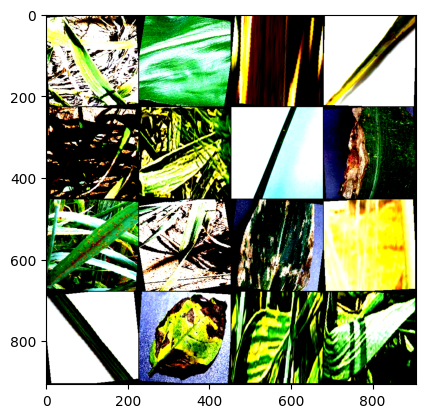

In [ ]:
def imshow(image_torch):
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(image_torch)

X_train, y_train = next(iter(train_loader))

# Make a grid from batch
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4)

imshow(image_grid)

6. Download and instantiate pre-trained network

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


  6.1 Freeze the layers

In [ ]:
#Freeze all layers
for params in model.parameters():
    params.requires_grad = False

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

In [ ]:
model = model.to(device)

7. Train the Model

In [ ]:
# %%
criterion = nn.CrossEntropyLoss()
train_losses=[]
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [ ]:
# Training and evaluation functions
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

In [ ]:
# Train loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    eval_loss, eval_acc = evaluate(model, eval_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}")

Epoch 1/10 | Train Acc: 0.7199, Eval Acc: 0.8647
Epoch 2/10 | Train Acc: 0.8354, Eval Acc: 0.8793
Epoch 3/10 | Train Acc: 0.8600, Eval Acc: 0.8939
Epoch 4/10 | Train Acc: 0.8727, Eval Acc: 0.9024
Epoch 5/10 | Train Acc: 0.8809, Eval Acc: 0.9024
Epoch 6/10 | Train Acc: 0.8831, Eval Acc: 0.9070
Epoch 7/10 | Train Acc: 0.8859, Eval Acc: 0.8978
Epoch 8/10 | Train Acc: 0.8902, Eval Acc: 0.9062
Epoch 9/10 | Train Acc: 0.8947, Eval Acc: 0.9085
Epoch 10/10 | Train Acc: 0.8929, Eval Acc: 0.9055


In [ ]:
# Evaluate on test set
def evaluate_test(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

y_true, y_pred = evaluate_test(model, test_loader)

In [ ]:
# Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Save the model
torch.save(model.state_dict(), "resnet50_crop_disease.pth")


Classification Report:
                             precision    recall  f1-score   support

         Corn___Common_Rust       0.96      0.99      0.98       120
      Corn___Gray_Leaf_Spot       0.90      0.71      0.80        52
             Corn___Healthy       0.99      1.00      1.00       117
Corn___Northern_Leaf_Blight       0.88      0.93      0.91        99
      Potato___Early_Blight       1.00      0.98      0.99       100
           Potato___Healthy       0.94      1.00      0.97        16
       Potato___Late_Blight       0.97      0.99      0.98       100
          Rice___Brown_Spot       0.66      0.63      0.64        62
             Rice___Healthy       0.69      0.91      0.78       149
          Rice___Leaf_Blast       0.73      0.39      0.51        98
          Rice___Neck_Blast       1.00      1.00      1.00       100
         Wheat___Brown_Rust       1.00      0.99      0.99        91
            Wheat___Healthy       1.00      1.00      1.00       112
        W

8. Evaluate the Model

9. Test the Model

10. Save Model

In [ ]:
# Define the model architecture
model = models.resnet50(pretrained=False)
model.eval()
# Modify the final layer to match the structure used during training
num_classes = 14
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

# Load the saved state_dict
model.load_state_dict(torch.load("resnet50_crop_disease.pth"))

# Set the model to evaluation mode (for inference)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

11. Loading the Model Weights

12. Performing Inference:

In [ ]:
# Sample inference for a new image

# Assume you have a test image that you want to classify
from PIL import Image

# Load your image
image_path = '/content/SDS-CP028/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn/Corn___Common_Rust/image (10).JPG'
image = Image.open(image_path)

# Apply the same transformations that you used for training
transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


image_tensor = transform_val(image).unsqueeze(0)  # Add batch dimension: (1, 1, 32, 32)

# Perform inference
with torch.no_grad():
    output = model(image_tensor)  # Forward pass
    _, predicted = torch.max(output, 1)  # Get the class with the highest score

# Print predicted class
predicted_class = CLASSES[predicted.item()]
print(f"Predicted class: {predicted_class}")


Predicted class: Corn___Common_Rust
